## Compare buildings/lot data from three city agencies: DOF, DCP, and DoITT.

Datasets with citywide data on building attributes and tax lots

DOF - FY 2017 Final Assessment Roll
http://www1.nyc.gov/site/finance/taxes/property-assessments.page
According to their data dictionary, this looks like a cut of their Real Property Assessment Data RPAD file.
YEAR4 column is all 2015, indicating this may be from last year.

DCP - Property Address Directory (PAD), PLUTO and MapPLUTO 
http://www1.nyc.gov/site/planning/data-maps/open-data.page
Feb 2016

DoITT - Buildings Footprints
https://data.cityofnewyork.us/Housing-Development/Building-Footprints/nqwf-w8eh
July 2016


Summary/Thoughts: 

* How many BBLs are there? Between 815k and 860k BBLs. A discrepancy of about 5% or 45k BBLs.
(DOF has a lot more BBLs, but it is likely a condo issue).

* When the datasets have BBLs in common, they mostly agree. Less than one percent of the time they disagree. However this still means thousands of buildings that don't agree.

* PLUTO and MapPLUTO always agree on building attributes, and are more likely to agree with DOF than DOITT.

* All of these datasets point to the same source for these three attributes (RPAD). So this is more likely a data problem as opposed to something like an interpretation difference.

* I don't see any obvious patterns with where they disagree. For instance it doesn't seem like newer buildings are more likely to be misrepresented. Which would be the case if there was a lag transfering data from one agency to another.

In [1]:
import pandas as pd
pd.options.display.max_columns=200
pd.options.display.float_format = '{:20.0f}'.format

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-poster')

from itertools import product
import numpy as np

import sys
sys.path.insert(0,'/home/deena/Documents/data_munge/ModaCode/')
import moda

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# reading in the data
# DOF
dof1 = pd.read_csv('/home/deena/Documents/data_munge/DOF/assessments/tc1.csv')
dof2 = pd.read_csv('/home/deena/Documents/data_munge/DOF/assessments/tc234.csv')
dof = pd.concat([dof1,dof2], ignore_index=True)
dof['BBL'] = moda.combineBBL(dof,boro='BORO',block='BLOCK',lot='LOT')

# DCP's PAD
pad_adr,pad_bbl = moda.readPad(billbbl_flag=1) #flag replaces condo bbls with their billing bbl
pad_bbl.rename(columns={'bbl':'BBL'},inplace=True)

# DCP's PLUTO
pluto = moda.readPluto()

# DCP's MapPLUTO (extracted csv from their shapefiles)
mapPluto = moda.readMapPlutoCSV()

# DOITT's building footprints
doitt = pd.read_csv('/home/deena/Documents/data_munge/BuildingFootprint_DOITT/building_footprints_shape.csv')

# Only keeping certain fields for each dataset
dofs = dof[['BBL','STORY','BLDGS','YRB','YRB_FLAG']]
dofs.rename(columns={col:'dof_'+col for col in dofs.columns[1:]},inplace=True)
dofs['dof'] = 1

pad = pad_bbl[['BBL']]
pad['pad'] = 1

plutos = pluto[['BBL','YearBuilt','BuiltCode','NumFloors','NumBldgs']]
plutos.rename(columns={col:'pluto_'+col for col in plutos.columns[1:]},inplace=True)
plutos['pluto'] = 1

mapPlutos = mapPluto[['BBL','YearBuilt','BuiltCode','NumFloors','NumBldgs']]
mapPlutos.rename(columns={col:'mappluto_'+col for col in mapPlutos.columns[1:]},inplace=True)
mapPlutos['mappluto'] = 1

doitts = doitt[['BBL','BIN','CNSTRCT_YR','BUILT_CODE','LSTSTATYPE','NUM_FLOORS']]
doitts.rename(columns={col:'doitt_'+col for col in doitts.columns[1:]},inplace=True)
doitts['doitt'] = 1

#combine into one df
comb = dofs.merge(plutos,how='outer',on='BBL')\
.merge(pad,how='outer',on='BBL')\
.merge(mapPlutos,how='outer',on='BBL')\
.merge(doitts,how='outer',on='BBL')


comb.head()

/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2871: DtypeWarning: Columns (0,4,53,87,90,93,97,100,103,106,109) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python2.7/dist-packages/IPython/core/interactiveshell.py:2871: DtypeWarning: Columns (0,4,39,40,41,43,45,46,53,66,77,87,90,93,97,100,103,106,109) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


PAD path /home/deena/Documents/data_munge/pad/pad16b/
PLUTO path: /home/deena/Documents/data_munge/pluto/nyc_pluto_16v1/
MapPLUTO path: /home/deena/Documents/data_munge/mappluto16v1/


,BBL,dof_STORY,dof_BLDGS,dof_YRB,dof_YRB_FLAG,dof,pluto_YearBuilt,pluto_BuiltCode,pluto_NumFloors,pluto_NumBldgs,pluto,pad,mappluto_YearBuilt,mappluto_BuiltCode,mappluto_NumFloors,mappluto_NumBldgs,mappluto,doitt_BIN,doitt_CNSTRCT_YR,doitt_BUILT_CODE,doitt_LSTSTATYPE,doitt_NUM_FLOORS,doitt
0,1000750043,4,1,1974,NaN,1,1974,NaN,4,1,1,1,1974,NaN,4,1,1,1001168,1974,NaN,Constructed,4,1
1,1000780040,5,1,1910,E,1,1910,E,5,1,1,1,1910,E,5,1,1,1001202,1910,E,Constructed,5,1
2,1000970017,5,1,1900,E,1,1900,E,5,1,1,1,1900,E,5,1,1,1001334,1900,E,Constructed,5,1
3,1000970036,4,1,1901,E,1,1901,E,4,1,1,1,1901,E,4,1,1,1001342,1901,E,Constructed,4,1
4,1000970044,4,1,1998,NaN,1,1998,NaN,4,1,1,1,1998,NaN,4,1,1,1086053,1998,NaN,Constructed,4,1


In [3]:
comb.count()

BBL                   2123824
dof_STORY             2120941
dof_BLDGS             2120941
dof_YRB               2120941
dof_YRB_FLAG           807131
dof                   2120941
pluto_YearBuilt       1881047
pluto_BuiltCode        860695
pluto_NumFloors       1881047
pluto_NumBldgs        1881047
pluto                 1881047
pad                   1880888
mappluto_YearBuilt    1867769
mappluto_BuiltCode     860475
mappluto_NumFloors    1867769
mappluto_NumBldgs     1867769
mappluto              1867769
doitt_BIN             1835586
doitt_CNSTRCT_YR      1835586
doitt_BUILT_CODE       858919
doitt_LSTSTATYPE      1835585
doitt_NUM_FLOORS      1835586
doitt                 1835586
dtype: int64

In [4]:
# how many BBLs are in all sets?
print 'BBLs in any of the datasets (union):', '{:,.0f}'.format(comb.drop_duplicates('BBL').shape[0])

index = ['dof', 'pad','pluto','mappluto','doitt']
print 'BBLs in all of the dataset (intersection):',\
'{:,.0f}'.format(comb[comb[index].sum(axis=1)==5].drop_duplicates('BBL').shape[0])


BBLs in any of the datasets (union): 1,101,648
BBLs in all of the dataset (intersection): 813,690


## BBL overlap (or intersection) of pairs of datasets

<img src="intersection.png",width=300, height=300, style="float: left;">

In [5]:
# find the overlap between any two the datasets, the number of bbls in set 1 and set 2

index = ['dof','pad','pluto','mappluto','doitt']
overlap = pd.DataFrame(index=index,columns=index)
for i, j in product(index,index):
    overlap.loc[i,j] = comb[(comb[i]==1)&(comb[j]==1)].drop_duplicates('BBL').shape[0]

overlap

,dof,pad,pluto,mappluto,doitt
dof,1099004,857346,858809,856824,813943
pad,857346,858998,857588,856981,814003
pluto,858809,857588,859205,857216,813906
mappluto,856824,856981,857216,857216,813755
doitt,813943,814003,813906,813755,815080


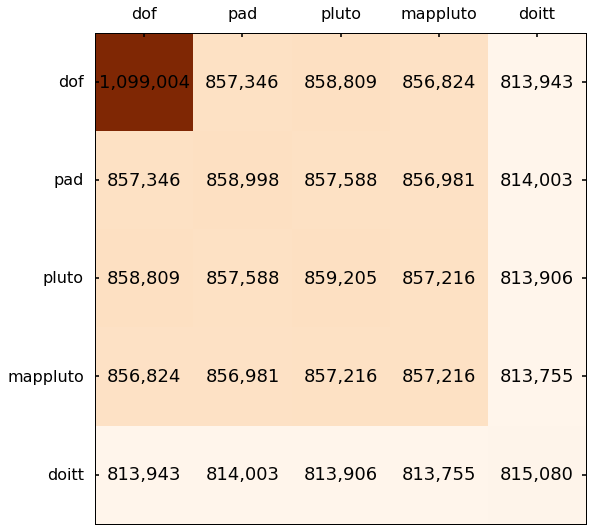

In [6]:
moda.heatmap(overlap)

* pad, pluto, mappluto have about the same number of BBLs, plus or minus 2k. 
* doitt's building footprints has about 40k less BBLs
* dof has over 100k more BBLs (I'm not sure why, it might partly be condos, but that seems really high)


## Complement of pairs of datasets

Complement of A in B: is not in A (row), but is in B (column)

<img src="complement.png",width=300, height=300, style="float: left;">


In [7]:
complement = pd.DataFrame(index=index,columns=index)
for i, j in product(index,index):
    complement.loc[i,j] = comb[(comb[i]!=1)&(comb[j]==1)].drop_duplicates('BBL').shape[0]

complement = complement.astype(float)
complement

,dof,pad,pluto,mappluto,doitt
dof,0,1652,396,392,1137
pad,241658,0,1617,235,1077
pluto,240195,1410,0,0,1174
mappluto,242180,2017,1989,0,1325
doitt,285061,44995,45299,43461,0


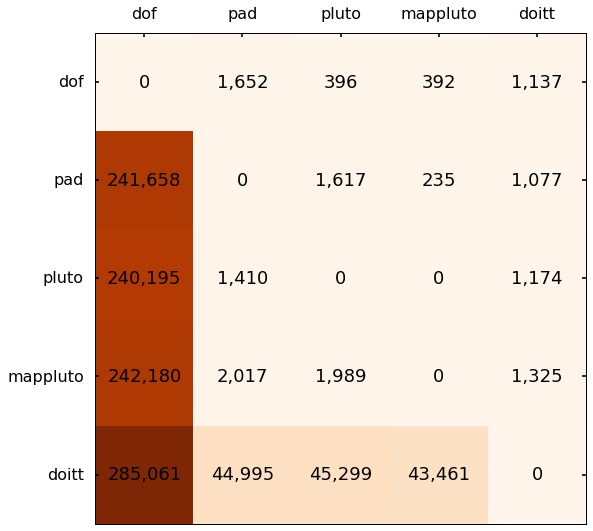

In [8]:
moda.heatmap(complement)

## Shared Attributes:
Do the different datasets agree on year built, number of floors, and number of buildings per lot?


### Year Built

Looking at the data dictionaries, PLUTO, MapPLUTO and DOITT all have a year built field that is attributed to RPAD. DOF Assessment Roll looks like it is a cut of RPAD. So naively one would expect all of them to agree.

Let's look at some plots below. Where they agree, they line up on the diagonal (x=y).


In [9]:
plt.style.use('ggplot')

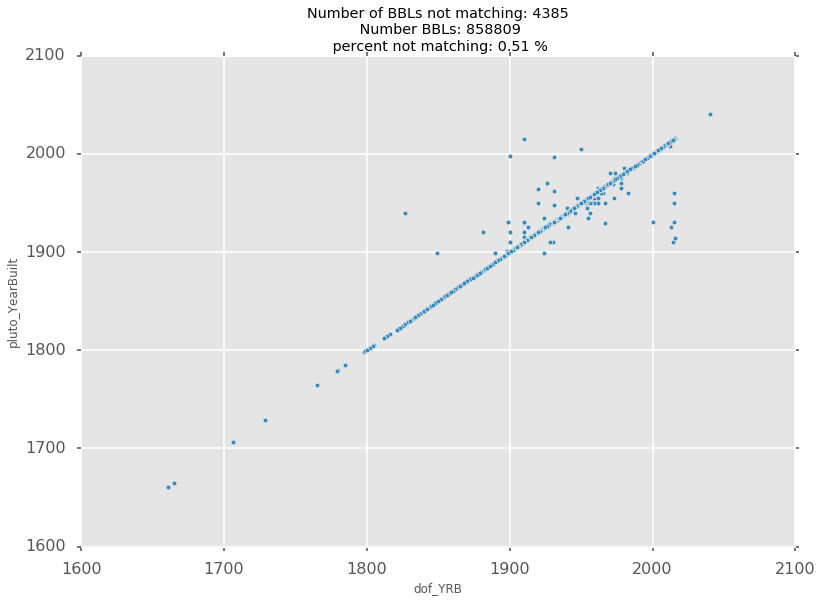

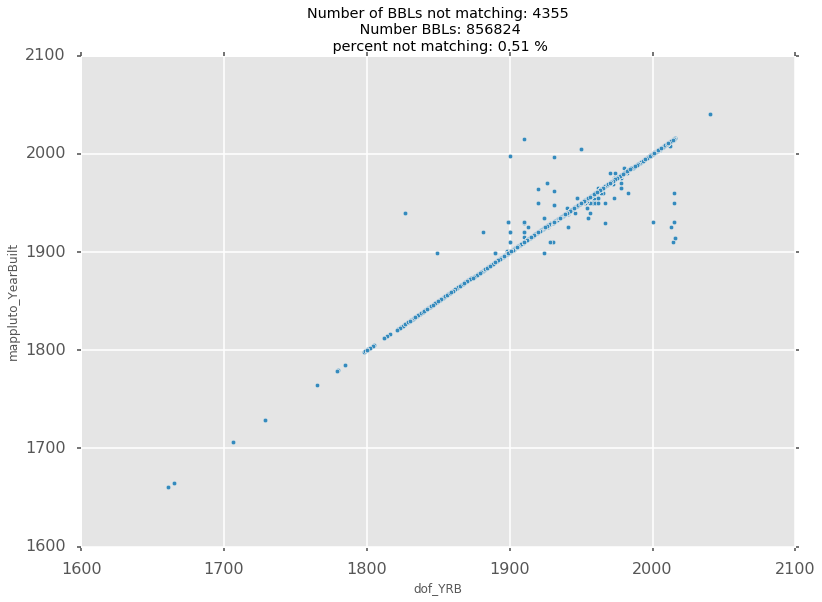

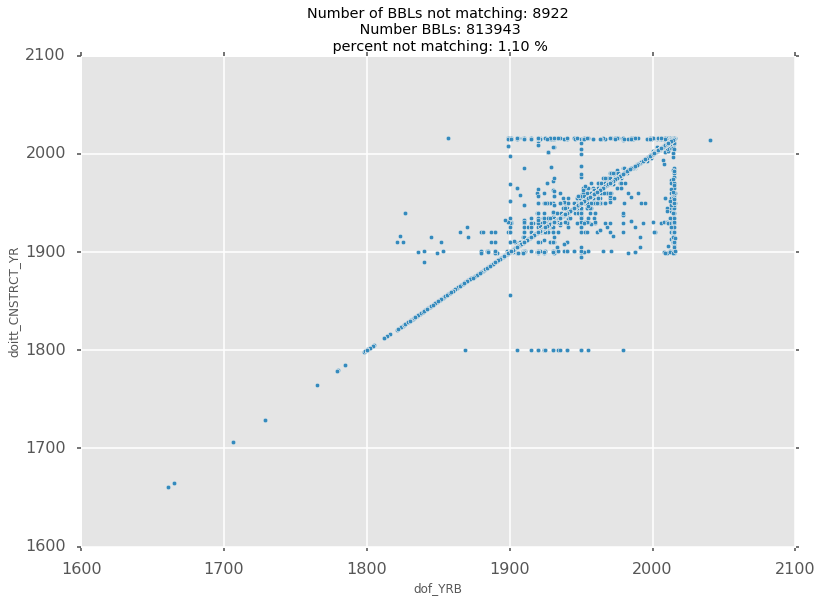

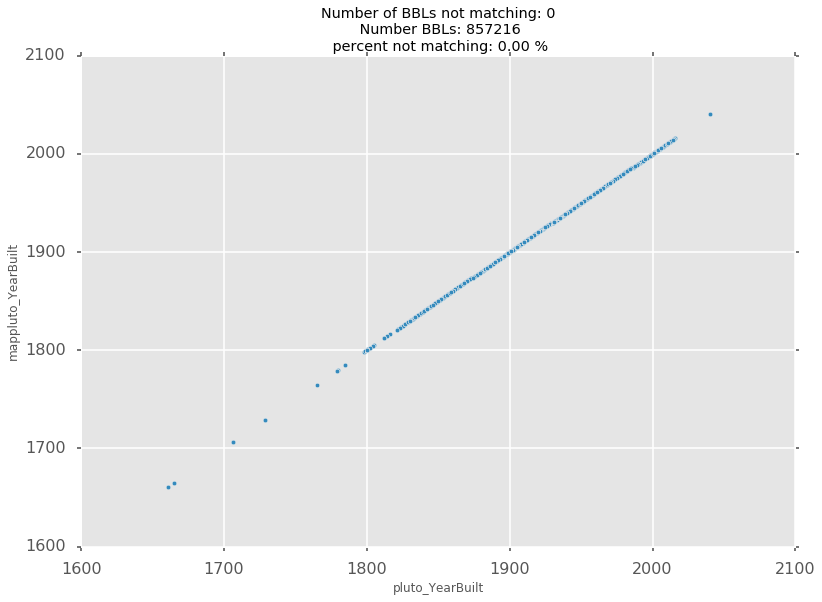

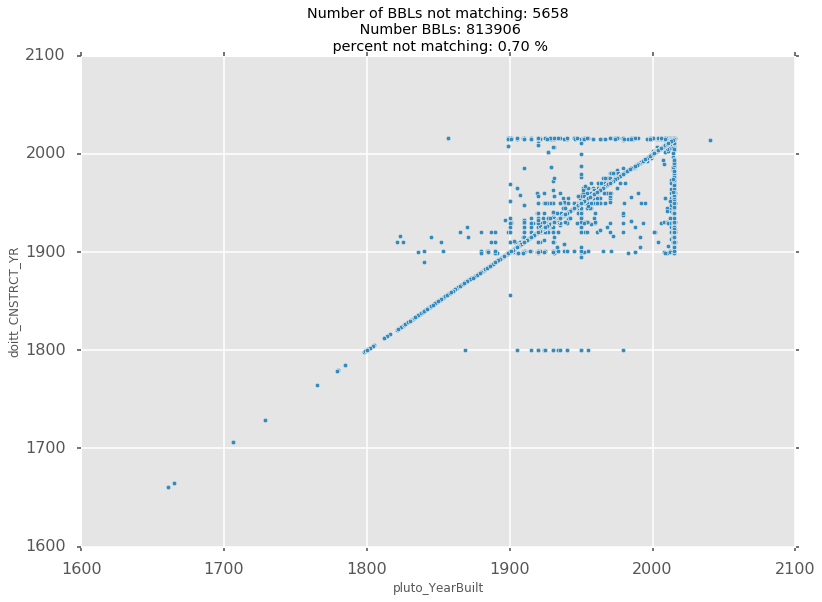

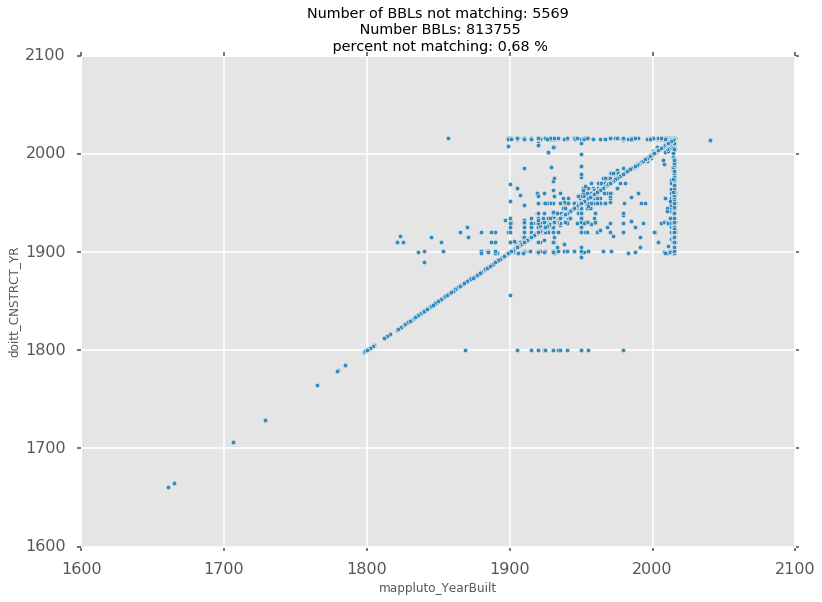

In [10]:
# year built columns
cols = ['dof_YRB', 'pluto_YearBuilt','mappluto_YearBuilt','doitt_CNSTRCT_YR']

for i,j in product(range(len(cols)),range(len(cols))):
    if i<j:
        BBLsNotMatch = comb[abs(comb[cols[i]]-comb[cols[j]])>2].drop_duplicates('BBL').shape[0]
        numberBBLs = comb[(comb[cols[i]]>=0)&(comb[cols[j]]>=0)].drop_duplicates('BBL').shape[0]
        pct = BBLsNotMatch/float(numberBBLs)*100
        # scatter plots
        comb.plot(kind='scatter',x=cols[i],y=cols[j],xlim=(1600,2100),ylim=(1600,2100),
                 title ='Number of BBLs not matching: ' + str(BBLsNotMatch) \
                 + '\n Number BBLs: '+str(numberBBLs) \
                  +'\n percent not matching: '+str('{:.2f}'.format(pct))+' %')
    

### Number of Floors

Again PLUTO, MapPLUTO, and DOITT all attribute their floors data to RPAD. So we would expect them to agree with DOF Assessment Rolls.

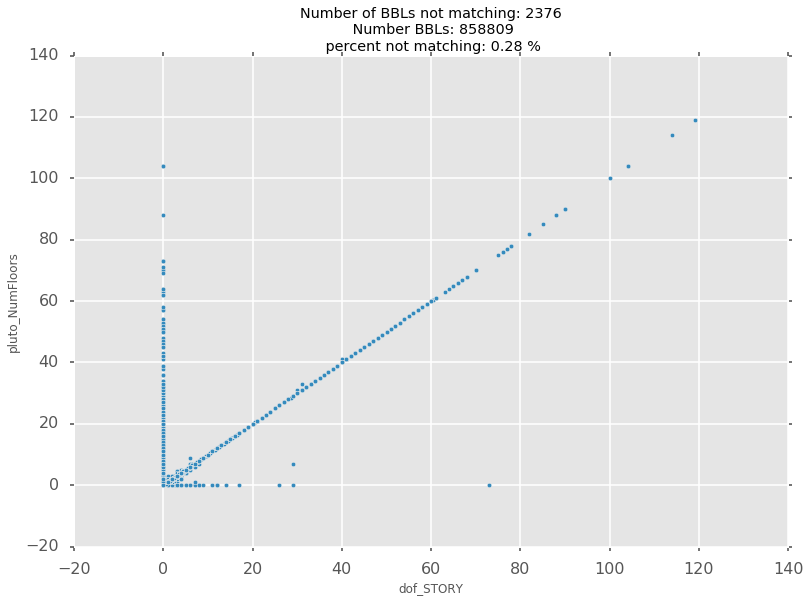

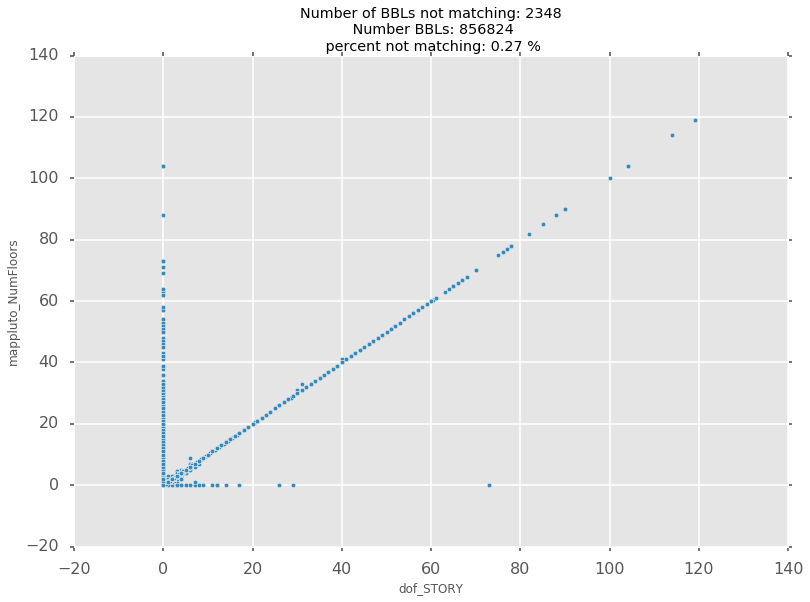

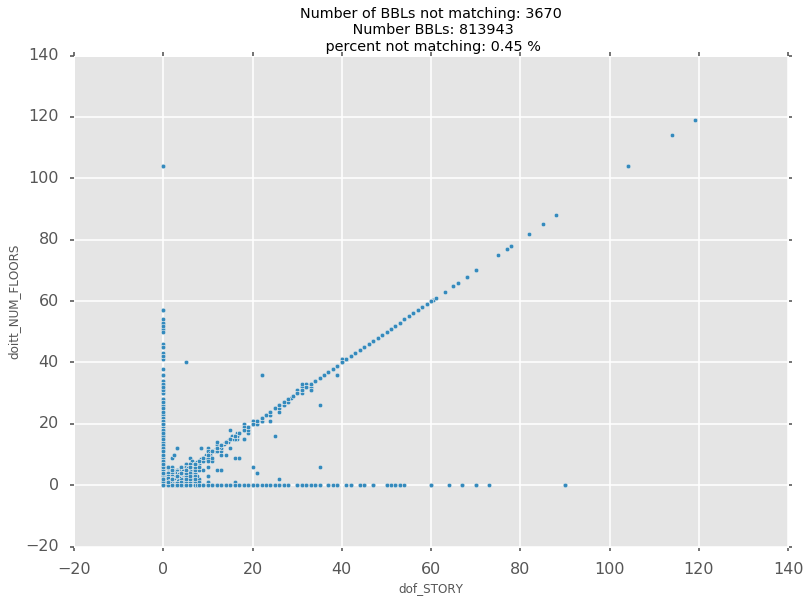

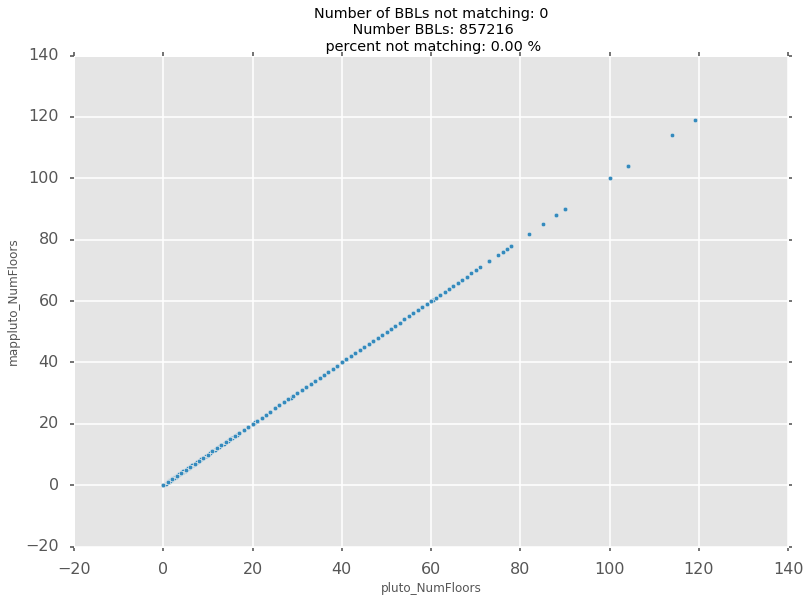

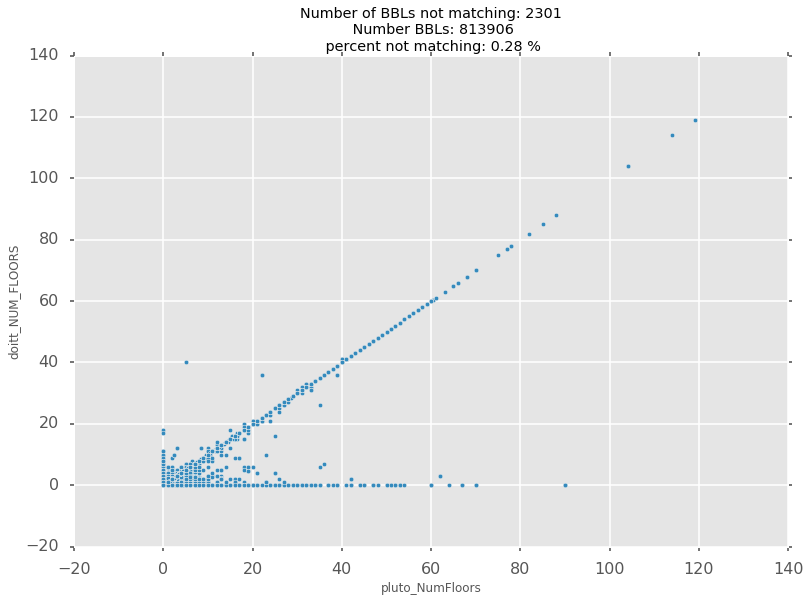

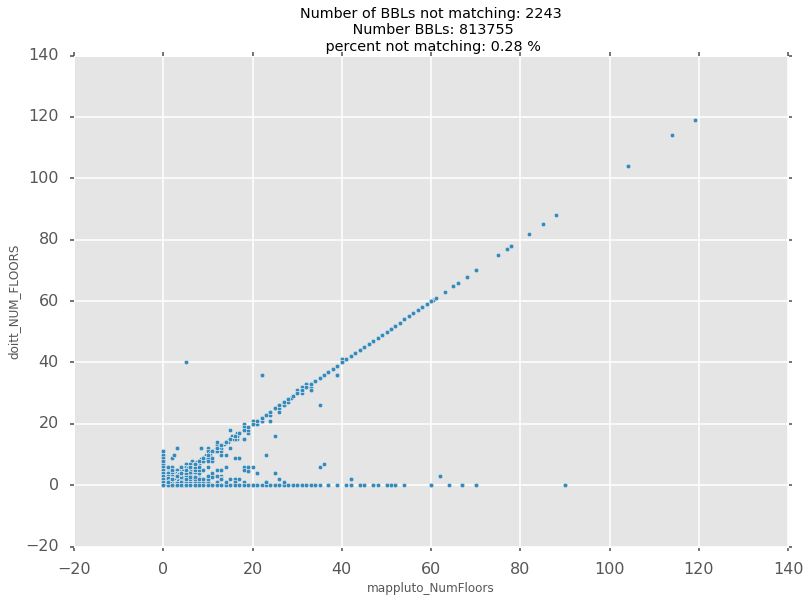

In [11]:
# number of floors columns:
cols = ['dof_STORY', 'pluto_NumFloors','mappluto_NumFloors','doitt_NUM_FLOORS']

for i,j in product(range(len(cols)),range(len(cols))):
    if i<j:
        BBLsNotMatch = comb[abs(comb[cols[i]]-comb[cols[j]])>2].drop_duplicates('BBL').shape[0]
        numberBBLs = comb[(comb[cols[i]]>=0)&(comb[cols[j]]>=0)].drop_duplicates('BBL').shape[0]
        pct = BBLsNotMatch/float(numberBBLs)*100
        # scatter plots
        comb.plot(kind='scatter',x=cols[i],y=cols[j],
                 title ='Number of BBLs not matching: ' + str(BBLsNotMatch) \
                 + '\n Number BBLs: '+str(numberBBLs) \
                  +'\n percent not matching: '+str('{:.2f}'.format(pct))+' %')
    


### Number of buildings per lot

PLUTO and MapPLUTO have the number of buildings on a tax lot field, attributed to RPAD.

While we see PLUTO and MapPLUTO have exactly the same number of buildins for the BBLs they have in common, they both differ from the DOF assemssment roll data.

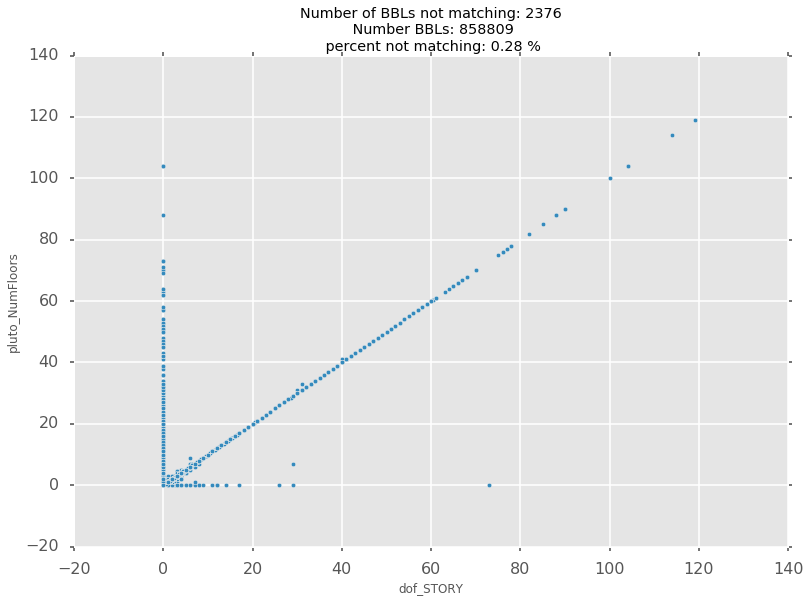

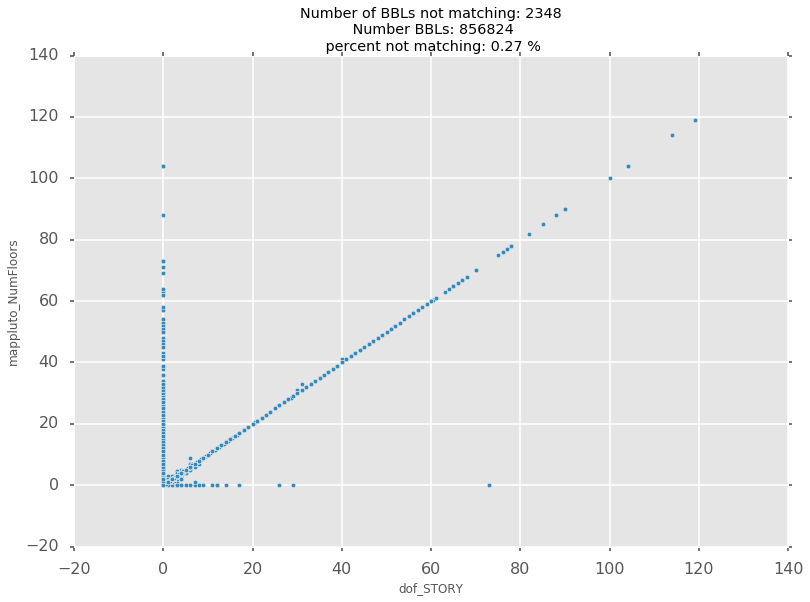

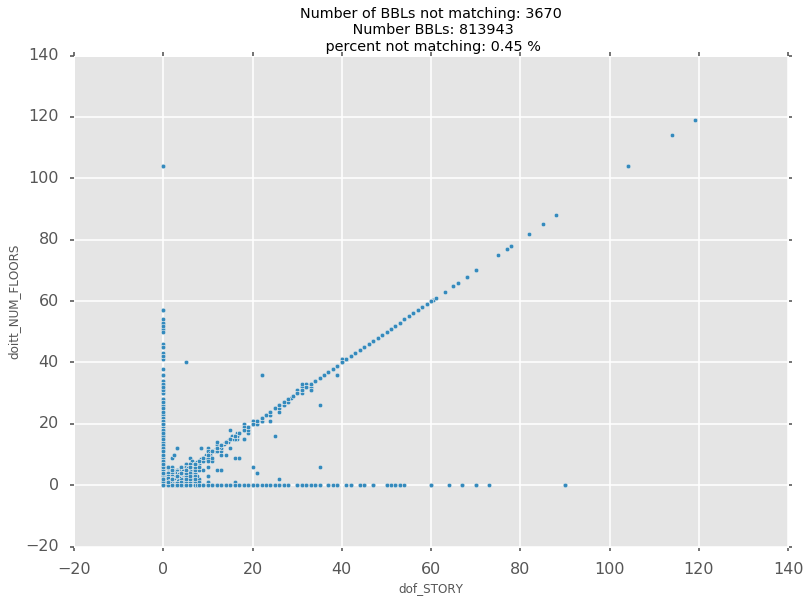

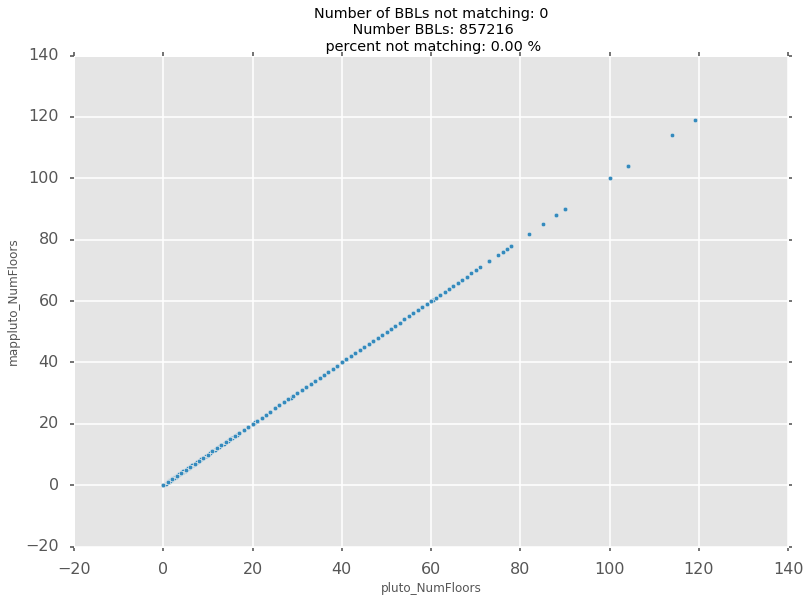

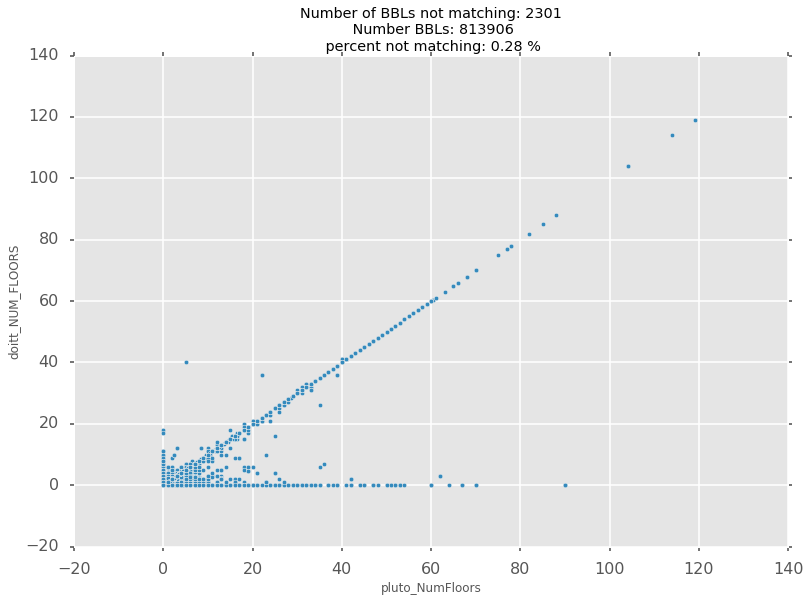

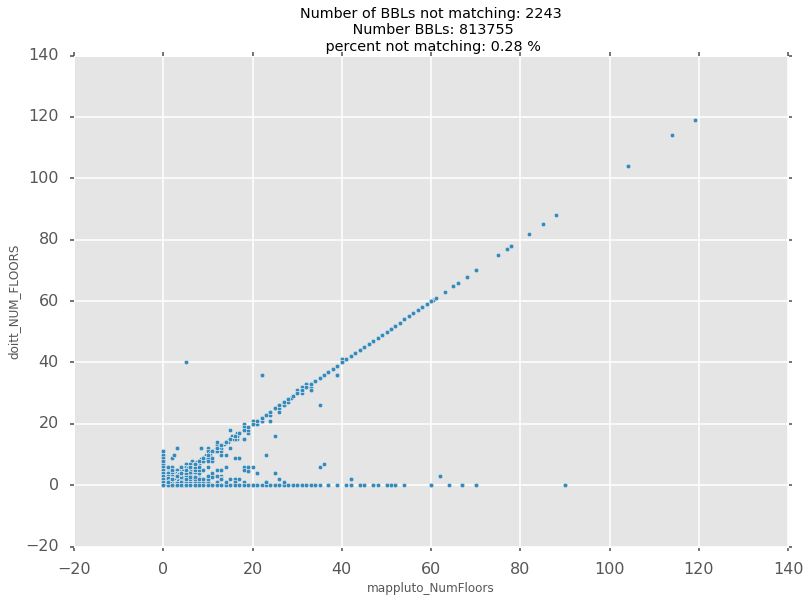

In [12]:
index = ['dof_BLDGS', 'pluto_NumBldgs','mappluto_NumBldgs']

for i,j in product(range(len(cols)),range(len(cols))):
    if i<j:
        BBLsNotMatch = comb[abs(comb[cols[i]]-comb[cols[j]])>2].drop_duplicates('BBL').shape[0]
        numberBBLs = comb[(comb[cols[i]]>=0)&(comb[cols[j]]>=0)].drop_duplicates('BBL').shape[0]
        pct = BBLsNotMatch/float(numberBBLs)*100
        # scatter plots
        comb.plot(kind='scatter',x=cols[i],y=cols[j],
                 title ='Number of BBLs not matching: ' + str(BBLsNotMatch) \
                 + '\n Number BBLs: '+str(numberBBLs) \
                  +'\n percent not matching: '+str('{:.2f}'.format(pct))+' %')
    